In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set parameters
base_dir = 'lab2_dataset'
img_height, img_width = 150, 150
batch_size = 32
num_classes = 4 # Update based on your classes

In [2]:
# Load dataset
classes = ['smokefire','smoke','nofire','fire']
data = []
labels = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            data.append(img_array)
            labels.append(classes.index(label))

data = np.array(data)
labels = np.array(labels)


In [3]:
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Data shape: (800, 150, 150, 3)
Labels shape: (800,)


In [4]:

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [5]:

# Load DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Unfreeze the entire model initially

# Add custom layers on top of DenseNet121
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Increased layer size
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # Additional dense layer
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)


In [6]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)  # Lower learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,  # Increased epochs
                    verbose=1)

Epoch 1/10


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.3219 - loss: 2.4714 - val_accuracy: 0.6125 - val_loss: 1.0019
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.5002 - loss: 1.3400 - val_accuracy: 0.7937 - val_loss: 0.6778
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6509 - loss: 0.8664 - val_accuracy: 0.8188 - val_loss: 0.4723
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7207 - loss: 0.6839 - val_accuracy: 0.8438 - val_loss: 0.3712
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7484 - loss: 0.5803 - val_accuracy: 0.8813 - val_loss: 0.3420
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7944 - loss: 0.5988 - val_accuracy: 0.8938 - val_loss: 0.2980
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7817 - loss: 0.5394 - val_accuracy: 0.9125 - val_loss: 0.2694
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8169 - loss: 0.4312 - val_accuracy: 0.9250 - val_loss: 0.2461
Ep

In [7]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


Validation Accuracy: 0.9250
Validation Loss: 0.2782


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step
Classification Report:
              precision    recall  f1-score   support

   smokefire       0.83      0.97      0.90        40
       smoke       0.97      0.82      0.89        40
      nofire       1.00      0.93      0.96        40
        fire       0.93      0.97      0.95        40

    accuracy                           0.93       160
   macro avg       0.93      0.92      0.93       160
weighted avg       0.93      0.93      0.93       160



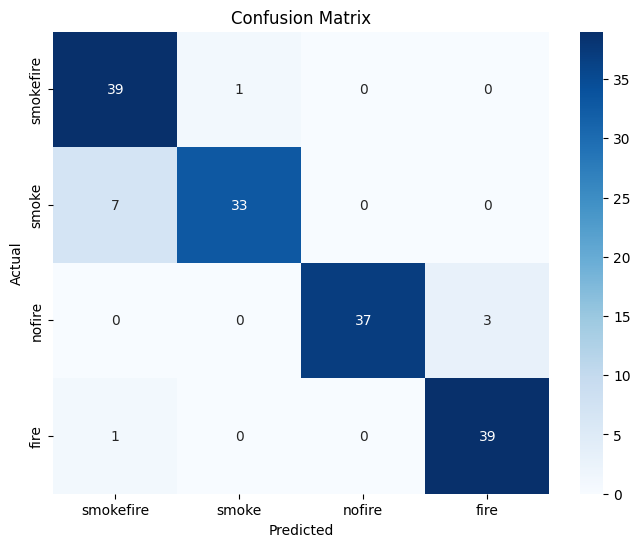

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


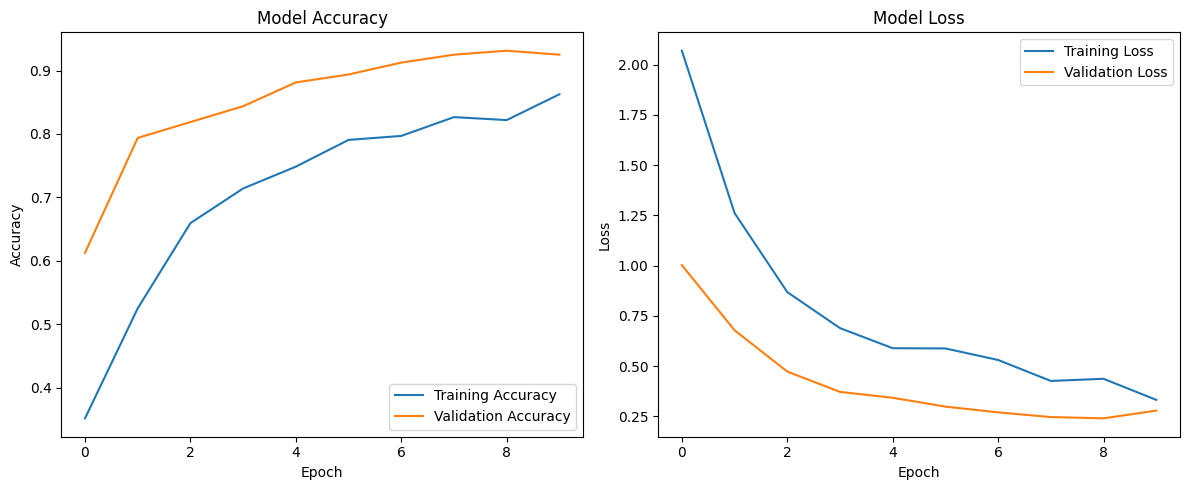

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


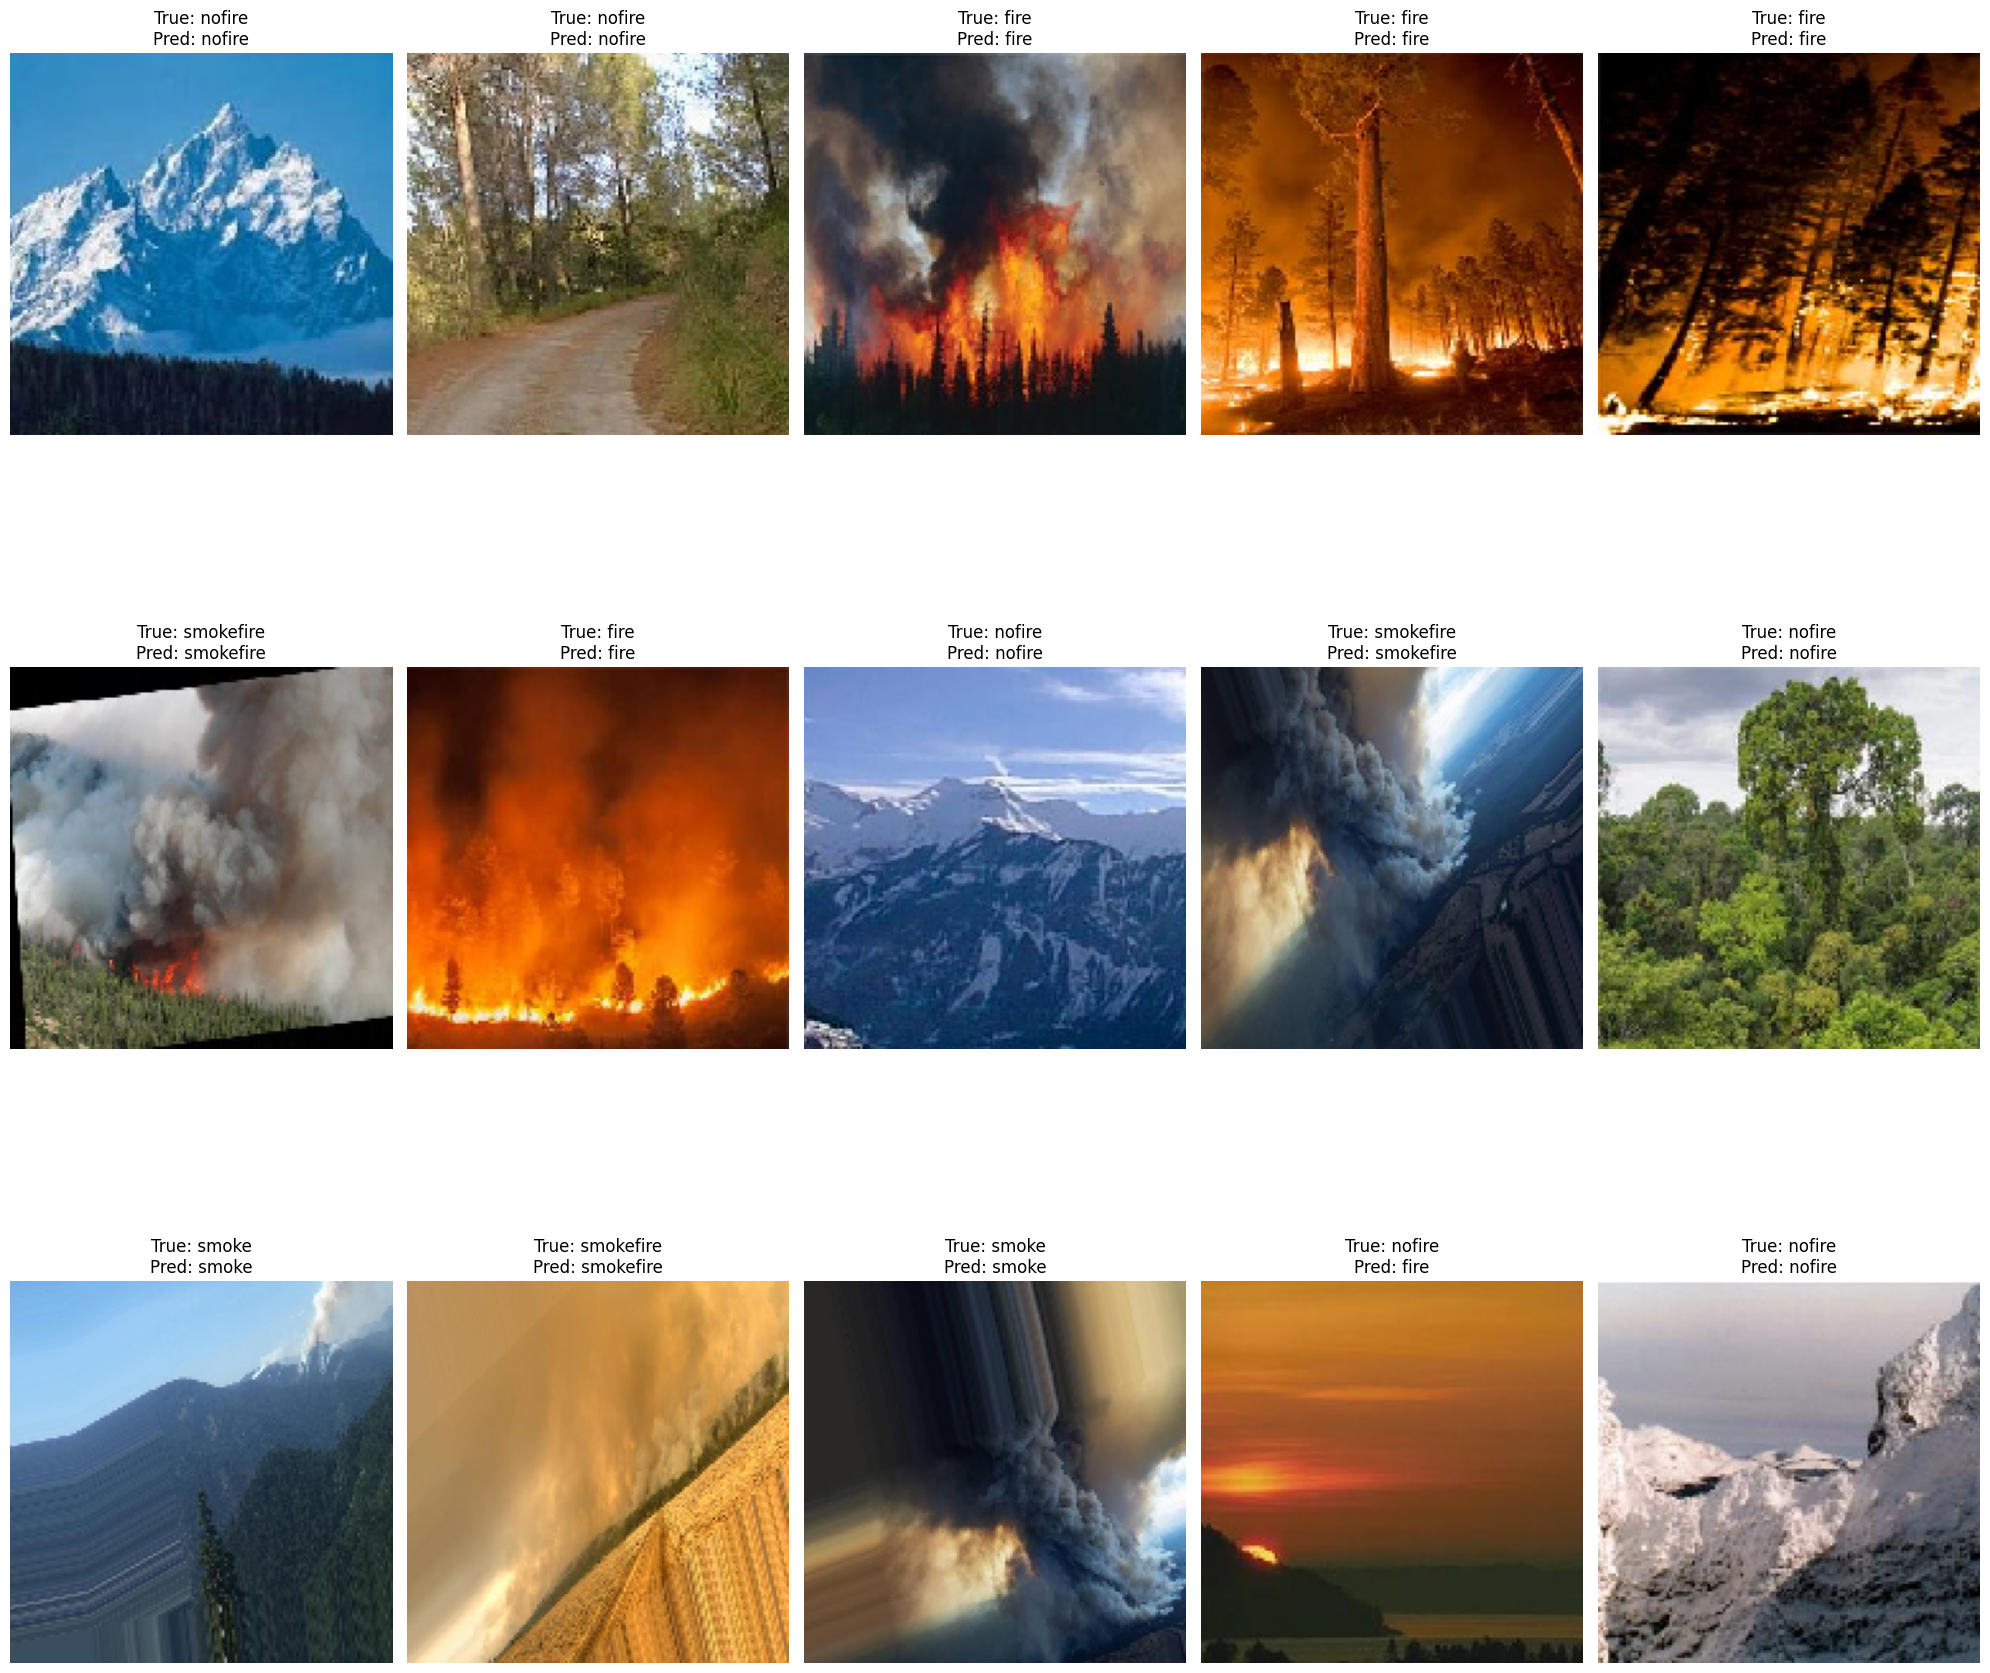

In [11]:
import random
import matplotlib.pyplot as plt

# Function to predict and visualize random images
def predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15):
    # Select random images from the base directory
    random_images = []
    for _ in range(num_images):
        random_class = random.choice(classes)
        folder_path = os.path.join(base_dir, random_class)
        random_file = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, random_file)
        random_images.append((img_path, random_class))

    # Plot the images with predictions
    plt.figure(figsize=(20, 20))
    for i, (img_path, true_class) in enumerate(random_images):
        # Load and preprocess the image
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = classes[np.argmax(prediction)]

        # Display the image with true and predicted labels
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize 15 predictions
predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15)


In [12]:
import os
print("Model successfully converted and saved as model.tflite.")
print("Current Working Directory:", os.getcwd())


Model successfully converted and saved as model.tflite.
Current Working Directory: C:\Users\Rishi\Downloads


In [14]:
model.save('hello.keras')

In [15]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted and saved as model.tflite.")

INFO:tensorflow:Assets written to: C:\Users\Rishi\AppData\Local\Temp\tmpmkeyye3r\assets


INFO:tensorflow:Assets written to: C:\Users\Rishi\AppData\Local\Temp\tmpmkeyye3r\assets


Saved artifact at 'C:\Users\Rishi\AppData\Local\Temp\tmpmkeyye3r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2939906658704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906661200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906660432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906656400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906659856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906659664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906660048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906660240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906658128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2939906662736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29399